In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import pdfminer
import glob
import scipy
import math
import random


import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer
#This block is just for importing relevant libraries

# Q1

Read Shannon's 1948 paper 'A Mathematical Theory of Communication'. Focus on pages 1-19 (up to Part II), the remaining part is more relevant for communication. http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf Summarize what you learned briely (e.g. half a page).

Shannon's paper, "A Mathematical Theory of Communication", aims to tackle a fundamental problem of communication (as of 1948) relating to noiseless communication systems. The first part of the paper provides a brief intuition for the choice of the logarithmic function for information transfer, and then defines a communication system in terms of five components. The first two components are information source which provides the information to be transmit, and transmitter, which encodes the message in the form of a signal that can be transmit. The last two components are receiver and destination, which are the inverse of the transmitter and source, respectively. The transmitter and receiver are connected by a channel which is the medium used to transmit the signal, and that is where noise is likely to be introduced.

The next few subsections look at the mathematial properties of discrete noiseless systems. Starting with the capacity of a channel, there is a brief discussion on allowable sequences, sources of information, approximations and n-grams. Generally, these sections try to lay the foundation for modern natural language processing (NLP), by talking about series of approximations to english, establishing sentences as a Markov (Markoff?) process and specifically, ergodic processes.

After this formulation, a measure of uncertainity is introduced. This measure is entropy, and it has to follow three properties relating to the probaility distribution, i.e., continuity, monotonically increasing funcion of number of choices and indifference to successive choices. The only function satisfying said properties is the proposed "Shannon" formula which defines entropy as:

$H = -K \Sigma_{i=1}^n p_i logp_i$

A few properties of this formula are explored such as behavior at extremes, behavior under joint distributions, conditional entropy, etc. The last few subsections talk about application of entropy to an information source, and how encoding/decoding operations can be represented to minimize the number of required bits. The fundamental theorem for a noiseless channel provides a hard upper bound for the avergae symbols per second transmitted for a given channel. Lastly, an example is provided to show how the average number of bits is obtained for a toy example with a special encoding scheme. 

# Q2

## Scraping, Entropy and ICML papers

ICML is a top research conference in Machine learning. Scrape all the pdfs of all ICML 2017 papers
from http://proceedings.mlr.press/v70/.
1. What are the top 10 common words in the ICML papers?

2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy of Z.

3. Synthesize a random paragraph using the marginal distribution over words.

4. (Extra credit) Synthesize a random paragraph using an n-gram model on words. Synthesize a random paragraph using any model you want. Top five synthesized text paragraphs win bonus (+30 points).

#### Preprocessing
This code block below reads in all pdf files and pastes the plaintext into one txt file.

In [2]:
class PdfConverter:

   def __init__(self, file_path):
       self.file_path = file_path
# convert pdf file to a string which has space among words 
   def convert_pdf_to_txt(self):
       rsrcmgr = PDFResourceManager()
       retstr = StringIO()
       codec = 'utf-8'  # 'utf16','utf-8'
       laparams = LAParams()
       device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
       fp = open(self.file_path, 'rb')
       interpreter = PDFPageInterpreter(rsrcmgr, device)
       password = ""
       maxpages = 0
       caching = True
       pagenos = set()
       for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
           interpreter.process_page(page)
       fp.close()
       device.close()
       str = retstr.getvalue()
       retstr.close()
       return str
# convert pdf file text to string and save as a text_pdf.txt file
   def save_convert_pdf_to_txt(self):
       content = self.convert_pdf_to_txt()
       txt_pdf = open('text_pdf.txt', 'ab')
       txt_pdf.write(content.encode('utf-8'))
       txt_pdf.close()
        
pdflist = glob.glob(r"C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\*.pdf")

for pdf in pdflist:
    print("Working on: " + pdf + '\n')
    pdfConverter = PdfConverter(file_path=pdf)
    #print(pdfConverter.convert_pdf_to_txt())
    pdfConverter.save_convert_pdf_to_txt()

Working on: C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\achab17a.pdf

Working on: C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\acharya17a.pdf

Working on: C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\achiam17a.pdf

Working on: C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\agarwal17a.pdf

Working on: C:\Users\priya\Dropbox\Sorted\UT Austin Academics\Fall 20\EE 460 Data science lab\Lab 3\ICML Papers\akrour17a.pdf



KeyboardInterrupt: 

#### Part a

In [2]:
# Read all the stored plain text from pdfs
with open ("text_pdf.txt", "r", encoding="utf-8") as myfile:
    text=myfile.readlines()

# create the transform
vectorizer = CountVectorizer()
# Tokenize and build vocabulary from the text corpus
vectorizer.fit(text)
# Summarize the vocabulary
data = vectorizer.vocabulary_

# This writes the words and counts to a txt file
with open('Word_counts.txt', 'w', encoding = "utf-8") as f:
    print(vectorizer.vocabulary_, file=f)

# A function is defined to return top n frequent words from a vocabulary list
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

get_top_n_words(text, 10)

[('the', 150968),
 ('of', 76160),
 ('and', 66081),
 ('in', 54055),
 ('to', 50705),
 ('cid', 46285),
 ('is', 40360),
 ('for', 36792),
 ('we', 34037),
 ('that', 24842)]

#### Part b

In [3]:
# This converts the counts to raw probabilities of appearance, and drops zero value words, i.e., so rare that their probability was rounded down to zero.
Prob_dist_raw = list(vectorizer.vocabulary_.values())
Prob_dist = []
sum_prob = sum(Prob_dist_raw)
for x in Prob_dist_raw:
    Prob_dist.append(x/sum_prob)
#print(Prob_dist)
Prob_dist = [i for i in Prob_dist if i != 0]

# Entropy calculation below
entropy = 0
for i in range(len(Prob_dist)):
    entropy = entropy + (Prob_dist[i]* math.log2(Prob_dist[i]))
entropy = entropy*(-1)
print("The Shannon entropy is calculated to be: ",entropy)

2374466328
The Shannon entropy is calculated to be:  15.793825595633031


#### Part c

In [4]:
# The block below returns n words chosen according to their probability of appearance
# This is a "paragraph" of 100 words.
n=100
keys = np.array(list(vectorizer.vocabulary_.keys()))
Probs = list(vectorizer.vocabulary_.values())
sum_prob = sum(Probs)
for x in range(len(Probs)):
    Probs[x] = Probs[x]/sum_prob
np.random.seed(2)
choice_list = np.random.choice(keys, n, replace=True, p=Probs)
print(choice_list)

['subtract' 'biological' 'mineig' 'proprietary' 'freq' 'kushal'
 'deeplearningbook' 'nowcasting' 'abilities' 'multimodal' 'χi' 'timally'
 'zerocomponentsinπ' 'tiallyhigherthanitsaccuracy' 'mfccs' 'lindsten'
 'fewcigarettesharmhealth' 'msr' 'uldas' 'ofﬁce' 'αpe' 'ues' 'u44' 'qi'
 'wherex' 'wiki10' 'yehuda' 'vaguely' 'friends' 'themis' 'gigabytes'
 'maharaj' 'teriori' 'unde' 'αpe' 'cussed' 'tilt' 'ρ2x2' 'swaps'
 'emulator' 'spaces1' 'recsys' 'memorisation' 'owing' 'κj' 'kathuria'
 'tuat' 'sαs' 'satb' 'zhenlong' 'τst' 'los' 'σd' 'ernment' 'ˆφk'
 'auxiliary' 'paving' 'bishop' 'selc' '991flop' 'roneously' 'version2'
 'wardsmoreintrinsicallymotivatedsolutionstocontinue' 's4'
 'whilethechatteringpersists' 'bothofthesedatasetshaveverylowerror' 'sθi'
 'purely' 'eliassi' 'polymorphism' 'c1n' 'popped' 'colmenarejo' 'harsh'
 'xxxi' 'x0sq' 'unblocked' 'operations' 'sivity' 'longing' 'nottingham'
 'inde' 'mehlhorn' 'dγit' 'huck' 'akinori' 'γ2' 'kstms' 'heave' 'gpus'
 'les' 'dπ' 'parameterizationmemo

#### Part d

In [9]:
# This block below tokenizes the word corpus
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize


#This tokenizes our text saved in variable text
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(str(text))]

# Preprocess the tokenized text for n-grams language modelling
n = 5
train_data, padded_sents = padded_everygram_pipeline(n, tokenized_text)


model = MLE(n)
print("The n-gram model is training now...")
model.fit(train_data, padded_sents)
print("The model has been trained successfully. The details are as follows:")
print(model.counts)

The n-gram model is training now...
The model has been trained successfully. The details are as follows:
<NgramCounter with 5 ngram orders and 34267605 ngrams>


In [10]:
detokenize = TreebankWordDetokenizer().detokenize

def generate_sentence(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)


for i in range(20):
    print("The random sentence number ",i," is: ")
    print(generate_sentence(model, 200, random_seed=i))

The random sentence number  0  is: 
probability of error and sim-\n' ,' ple is used for neural variational inference.
The random sentence number  1  is: 
' modeling that is entirely convolutional.
The random sentence number  2  is: 
was used, as we had stability issues with smaller\n' ,' network rnns trained on the tidigits digit recognition\n' ,' \n' ,' 80\n' ,' \n' ,' where zt = β1zt−1 + (1 − ρt) αu) ] \n' ,' the graph was important for good predictive performance.\n' ,' \n' ,' x1, x2, . . ., k.
The random sentence number  3  is: 
+\n' ,' \n' ,' \n' ,' the main motivation for consid-\n' ,' ered, the training cost can be reduced to the optimization problem, so running the model in real-time may\n' ,' be learned from data.\n' ,' as well as when α grows sub-linearly to n .\n' ,' \n' ,' ≤ (cid : 107) xs\n' ,' (cid : 88) \n' ,' i=1\n' ,' \n' ,' \n' ,' and o( n2) space\n' ,' embeddings of entities and relations can be\n' ,' \n' ,' isurvive, has three components: (1) while keeping the same 

# Q3

## Starting in Kaggle

Soon you will be participating in the in-class Kaggle competition made for this class. In that one, you will be participating on your own. This is a warmup- the more eort and research you put into this assignment the easier it will be to compete into the real Kaggle competition that you will need to do soon. We expect you to spend 10 times more eort on this problem compared to the others.

1. Let's start with our first Kaggle submission in a playground regression competition. Make an account to Kaggle and find https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

2. Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models. Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get? (Hint: remember to exponentiate np.expm1(ypred) your predictions).

3. Compare a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

4. Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the strength of regularization parameter alpha.

5. Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit. What score can you get? (We will be discussing ensembling more, later in the class, but you can start playing with it now).

6. Install XGBoost (Gradient Boosting) and train a gradient boosting regression. What score can you get just from a single XGB? (you will need to optimize over its parameters). We will discuss boosting and gradient boosting in more detail later. XGB is a great friend to all good Kagglers!

7. Do your best to get the more accurate model. Try feature engineering and stacking many models. You are allowed to use any public tool in python. No non-python tools allowed.

8. (Optional) Read the Kaggle forums, tutorials and Kernels in this competition. This is an excellent way to learn. Include in your report if you find something in the forums you like, or if you made your own post or code post, especially if other Kagglers liked or used it afterwards.

9. Be sure to read and learn the rules of Kaggle! No sharing of code or data outside the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with partners. This is more important for live competitions of course.

10. As in the real in-class Kaggle competition (which will be next), you will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report (that you will submit as a pdf file), explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. We will invite teams with interesting solutions to present them in class.

In [2]:
#This block reads the necessary input files

train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")


print(train.head())

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D50D54DA20>,
      dtype=object)

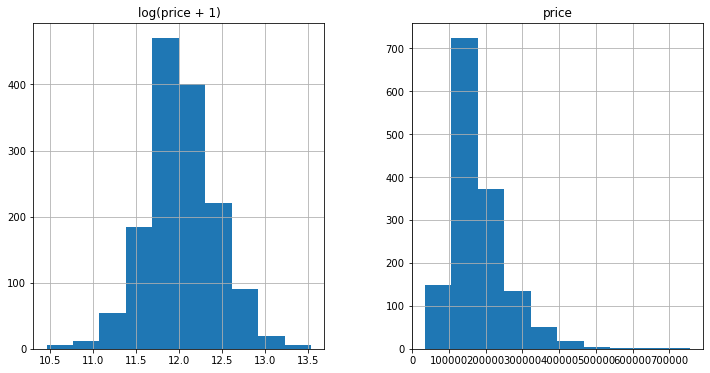

In [3]:
#Data pre-processing as given in link

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [4]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Models

In [5]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#### Regressions

In [6]:
model_ridge = Ridge()

alpha = 0.1
cv_ridge = rmse_cv(Ridge(alpha = alpha)).mean()

print(cv_ridge)

model_ridge.fit(X_train, y)

0.13777538277187837


Ridge()

#### This block is for making prediction using ridge regression

In [24]:
ypred = model_ridge.predict(X_test)

SalePrice = np.expm1(ypred)

SalePrice_arr = ["Id"]
for i in range(len(SalePrice)):
    SalePrice_arr.append(SalePrice[i])
    
Id_list = ["SalePrice"]
for i in range(len(test.Id)):
    Id_list.append(test.Id[i])
    
f = open("Ridge.csv", "w")
f.write(str(Id_list))
f.write("\n")
f.write(str(SalePrice_arr))
f.close()

### Kaggle Score

This provides a Kaggle score of 0.13043

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
rmse_cv(model_lasso).mean()
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")